# 제조 라인 이상(불량) 탐지 프로젝트
# Manufacturing Line Anomaly Detection Project

---

## 문제 개요 / Problem Overview

제조 라인에서 발생하는 최종 불량(EOL Fail)을 예측하기 위해 **지도 학습**과 **비지도 학습**을 결합하여 이상 발생 위험도를 확률(score) 형태로 산출하고, 운영 현장에 적용 가능한 임계값 기준(Threshold Policy)을 제시합니다.

### 평가 항목 / Evaluation Criteria
| 구분 | 요구 수준 |
|------|----------|
| 데이터 탐색 | 구조, 분포, 불균형 분석 |
| 전처리 | 범주형/수치형 분리 및 변환 |
| 피처 추출 | **비지도 표현 학습** 또는 자체 피처 엔지니어링 |
| 모델링 | 분류 모델 자유 선택 |
| 임계값 탐색 | F1 최적 vs Top 5% 비교 |
| 코드 완결성 | 오류 없이 실행 가능한 구조 |

---
## 0. 환경 설정 / Environment Setup

In [1]:
# ============================================================
# 라이브러리 임포트 / Library Imports
# ============================================================
import os
import random
import warnings
from pathlib import Path

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
from sklearn.ensemble import IsolationForest
from sklearn.metrics import (
    accuracy_score, precision_score, recall_score, f1_score,
    roc_auc_score, average_precision_score, classification_report,
    confusion_matrix, precision_recall_curve
)
from imblearn.over_sampling import SMOTE
from xgboost import XGBClassifier

warnings.filterwarnings('ignore')
plt.rcParams['figure.figsize'] = (10, 6)
sns.set_style('whitegrid')

print('✅ 라이브러리 로드 완료')

✅ 라이브러리 로드 완료


In [2]:
# 재현성을 위한 시드 설정
SEED = 42
random.seed(SEED)
np.random.seed(SEED)
os.environ['PYTHONHASHSEED'] = str(SEED)
print(f'✅ 랜덤 시드 설정: {SEED}')

✅ 랜덤 시드 설정: 42


---
## 1️⃣ 데이터 로딩 및 탐색

In [3]:
# 데이터 로딩
CSV_PATH = Path('manufacturing_error_dataset_v2.csv')
if not CSV_PATH.exists():
    import gdown
    gdown.download('https://drive.google.com/uc?id=1GPFqmquPgvcLQQqSem3OPhR-hT7zStB2', str(CSV_PATH), quiet=False)

df = pd.read_csv(CSV_PATH)
print(f'데이터 Shape: {df.shape}')

# 컬럼 분류
TARGET_COL = 'eol_fail'
CAT_COLS = ['line_id', 'shift', 'supplier', 'material_grade']
NUM_COLS = [c for c in df.columns if c not in CAT_COLS + [TARGET_COL]]

print(f'타겟: {TARGET_COL}')
print(f'범주형 ({len(CAT_COLS)}개): {CAT_COLS}')
print(f'수치형 ({len(NUM_COLS)}개): {NUM_COLS}')

데이터 Shape: (2500, 16)
타겟: eol_fail
범주형 (4개): ['line_id', 'shift', 'supplier', 'material_grade']
수치형 (11개): ['machine_age_months', 'last_maint_days', 'operator_experience_yrs', 'ambient_temp_c', 'ambient_humidity_pct', 'vibration_rms', 'hydraulic_pressure_bar', 'defect_history_count_90d', 'prev_batch_quality_score', 'tool_wear_mm', 'scrap_rate_pct_line_week']


결측치: 0

Class 0 (정상): 2,125개 (85.0%)
Class 1 (불량): 375개 (15.0%)
불균형 비율: 5.67:1


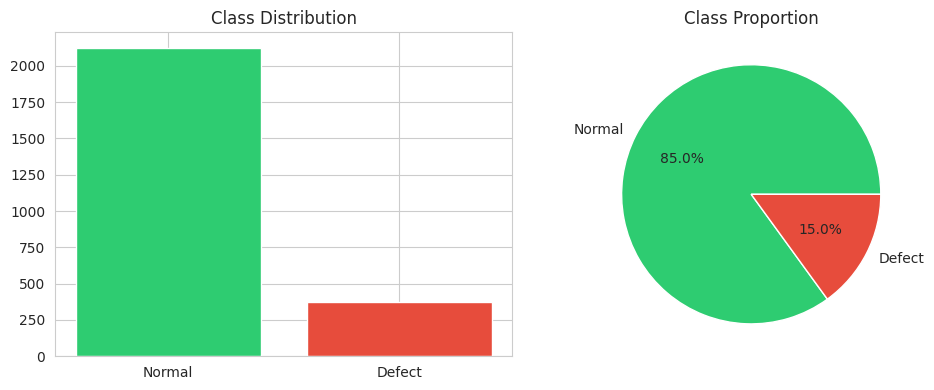

In [4]:
# 결측치 확인
print('결측치:', df.isnull().sum().sum())

# 클래스 불균형 분석
class_counts = df[TARGET_COL].value_counts().sort_index()
class_ratio = class_counts / len(df) * 100
imbalance_ratio = class_counts[0] / class_counts[1]

print(f'\nClass 0 (정상): {class_counts[0]:,}개 ({class_ratio[0]:.1f}%)')
print(f'Class 1 (불량): {class_counts[1]:,}개 ({class_ratio[1]:.1f}%)')
print(f'불균형 비율: {imbalance_ratio:.2f}:1')

# 시각화
fig, ax = plt.subplots(1, 2, figsize=(10, 4))
ax[0].bar(['Normal', 'Defect'], class_counts.values, color=['#2ecc71', '#e74c3c'])
ax[0].set_title('Class Distribution')
ax[1].pie(class_counts.values, labels=['Normal', 'Defect'], autopct='%1.1f%%', colors=['#2ecc71', '#e74c3c'])
ax[1].set_title('Class Proportion')
plt.tight_layout()
plt.show()

In [5]:
# 기술통계
print(df[NUM_COLS].describe().T.round(3))

                           count     mean     std     min      25%      50%  \
machine_age_months        2500.0   89.319  51.666   3.000   44.000   89.000   
last_maint_days           2500.0   60.434  34.297   1.000   30.000   61.000   
operator_experience_yrs   2500.0    5.849   3.422   0.000    2.800    5.800   
ambient_temp_c            2500.0   24.093   4.495   6.500   21.000   24.000   
ambient_humidity_pct      2500.0   55.573  11.944  15.900   47.875   55.500   
vibration_rms             2500.0    1.832   0.609   0.028    1.405    1.825   
hydraulic_pressure_bar    2500.0  115.132  11.768  76.700  107.300  115.250   
defect_history_count_90d  2500.0    1.196   1.118   0.000    0.000    1.000   
prev_batch_quality_score  2500.0   91.979   4.861  75.800   88.700   92.200   
tool_wear_mm              2500.0    0.352   0.175   0.020    0.227    0.347   
scrap_rate_pct_line_week  2500.0    2.829   1.463   0.000    1.800    2.810   

                              75%      max  
machin

---
## 2️⃣ 피처 추출 및 전처리

In [6]:
# Train/Valid 분할 (80:20, Stratified)
X = df.drop(columns=[TARGET_COL])
y = df[TARGET_COL].astype(int)

X_train, X_valid, y_train, y_valid = train_test_split(X, y, test_size=0.2, random_state=SEED, stratify=y)
X_valid_original = X_valid.copy()

print(f'Train: {X_train.shape[0]}, Valid: {X_valid.shape[0]}')

Train: 2000, Valid: 500


In [7]:
# 이상치 탐지 및 제거 (IQR)
def detect_outliers_iqr(df, columns, threshold=1.5):
    outlier_indices = set()
    for col in columns:
        Q1, Q3 = df[col].quantile(0.25), df[col].quantile(0.75)
        IQR = Q3 - Q1
        col_outliers = df[(df[col] < Q1 - threshold*IQR) | (df[col] > Q3 + threshold*IQR)].index
        outlier_indices.update(col_outliers)
    return outlier_indices

train_outliers = detect_outliers_iqr(X_train, NUM_COLS)
valid_outliers = detect_outliers_iqr(X_valid, NUM_COLS)

X_train_clean = X_train.drop(index=list(train_outliers)).reset_index(drop=True)
y_train_clean = y_train.drop(index=list(train_outliers)).reset_index(drop=True)
X_valid_clean = X_valid.drop(index=list(valid_outliers)).reset_index(drop=True)
y_valid_clean = y_valid.drop(index=list(valid_outliers)).reset_index(drop=True)
X_valid_orig_clean = X_valid_original.drop(index=list(valid_outliers)).reset_index(drop=True)

print(f'이상치 제거: Train {len(X_train)}→{len(X_train_clean)}, Valid {len(X_valid)}→{len(X_valid_clean)}')

이상치 제거: Train 2000→1933, Valid 500→484


In [8]:
# 범주형 One-Hot 인코딩
X_train_cat = pd.get_dummies(X_train_clean[CAT_COLS], columns=CAT_COLS, dtype=int)
X_valid_cat = pd.get_dummies(X_valid_clean[CAT_COLS], columns=CAT_COLS, dtype=int)
X_valid_cat = X_valid_cat.reindex(columns=X_train_cat.columns, fill_value=0)

# 수치형 StandardScaler
scaler = StandardScaler()
X_train_num = scaler.fit_transform(X_train_clean[NUM_COLS])
X_valid_num = scaler.transform(X_valid_clean[NUM_COLS])
X_train_num_df = pd.DataFrame(X_train_num, columns=NUM_COLS)
X_valid_num_df = pd.DataFrame(X_valid_num, columns=NUM_COLS)

print(f'One-Hot 인코딩: {X_train_cat.shape[1]}개 컬럼')
print(f'StandardScaler 적용 완료')

One-Hot 인코딩: 16개 컬럼
StandardScaler 적용 완료


In [9]:
# 비지도 학습 잠재 특징 추출
# [1] PCA (3 components)
pca = PCA(n_components=3, random_state=SEED)
pca_train = pca.fit_transform(X_train_num)
pca_valid = pca.transform(X_valid_num)
pca_train_df = pd.DataFrame(pca_train, columns=['pca_1', 'pca_2', 'pca_3'])
pca_valid_df = pd.DataFrame(pca_valid, columns=['pca_1', 'pca_2', 'pca_3'])
print(f'PCA 설명 분산: {sum(pca.explained_variance_ratio_)*100:.1f}%')

# [2] Isolation Forest (Anomaly Score)
iso_forest = IsolationForest(n_estimators=100, contamination=0.15, random_state=SEED)
iso_forest.fit(X_train_num)
iso_train_df = pd.DataFrame({'iso_anomaly_score': -iso_forest.decision_function(X_train_num)})
iso_valid_df = pd.DataFrame({'iso_anomaly_score': -iso_forest.decision_function(X_valid_num)})

# [3] K-Means Clustering
kmeans = KMeans(n_clusters=5, random_state=SEED, n_init=10)
kmeans.fit(X_train_num)
cluster_train_df = pd.DataFrame({'cluster_label': kmeans.predict(X_train_num), 'cluster_distance': kmeans.transform(X_train_num).min(axis=1)})
cluster_valid_df = pd.DataFrame({'cluster_label': kmeans.predict(X_valid_num), 'cluster_distance': kmeans.transform(X_valid_num).min(axis=1)})

print('비지도 잠재 특징: PCA(3) + IsolationForest(1) + KMeans(2) = 6개')

PCA 설명 분산: 29.3%
비지도 잠재 특징: PCA(3) + IsolationForest(1) + KMeans(2) = 6개


In [10]:
# 최종 피처셋 구성
X_train_cat = X_train_cat.reset_index(drop=True)
X_valid_cat = X_valid_cat.reset_index(drop=True)

X_train_final = pd.concat([X_train_num_df, X_train_cat, pca_train_df, iso_train_df, cluster_train_df], axis=1)
X_valid_final = pd.concat([X_valid_num_df, X_valid_cat, pca_valid_df, iso_valid_df, cluster_valid_df], axis=1)
y_train_final = y_train_clean
y_valid_final = y_valid_clean

print(f'최종 피처 수: {X_train_final.shape[1]}개')
print(f'Train: {X_train_final.shape}, Valid: {X_valid_final.shape}')

최종 피처 수: 33개
Train: (1933, 33), Valid: (484, 33)


---
## 3️⃣ 지도 학습 모델 설계 및 학습

In [11]:
# SMOTE로 불균형 대응
print(f'SMOTE 전: Class 0={sum(y_train_final==0)}, Class 1={sum(y_train_final==1)}')
smote = SMOTE(random_state=SEED)
X_train_resampled, y_train_resampled = smote.fit_resample(X_train_final, y_train_final)
print(f'SMOTE 후: Class 0={sum(y_train_resampled==0)}, Class 1={sum(y_train_resampled==1)}')

SMOTE 전: Class 0=1648, Class 1=285
SMOTE 후: Class 0=1648, Class 1=1648


In [12]:
# XGBoost 모델 학습
scale_pos_weight = sum(y_train_final==0) / sum(y_train_final==1)

model = XGBClassifier(
    objective='binary:logistic',
    n_estimators=200, max_depth=5, learning_rate=0.1,
    subsample=0.8, colsample_bytree=0.8,
    scale_pos_weight=scale_pos_weight,
    random_state=SEED, eval_metric='logloss', use_label_encoder=False
)
model.fit(X_train_resampled, y_train_resampled)
print('✅ XGBoost 모델 학습 완료')

✅ XGBoost 모델 학습 완료


Accuracy:  0.9360
Precision: 0.7857
Recall:    0.7746
F1-Score:  0.7801
ROC-AUC:   0.9599

              precision    recall  f1-score   support

      Normal       0.96      0.96      0.96       413
      Defect       0.79      0.77      0.78        71

    accuracy                           0.94       484
   macro avg       0.87      0.87      0.87       484
weighted avg       0.94      0.94      0.94       484



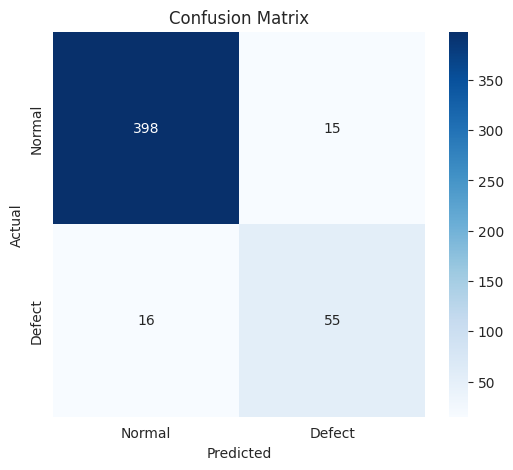

In [13]:
# 모델 평가
y_pred = model.predict(X_valid_final)
y_pred_proba = model.predict_proba(X_valid_final)[:, 1]

print(f'Accuracy:  {accuracy_score(y_valid_final, y_pred):.4f}')
print(f'Precision: {precision_score(y_valid_final, y_pred):.4f}')
print(f'Recall:    {recall_score(y_valid_final, y_pred):.4f}')
print(f'F1-Score:  {f1_score(y_valid_final, y_pred):.4f}')
print(f'ROC-AUC:   {roc_auc_score(y_valid_final, y_pred_proba):.4f}')

print('\n' + classification_report(y_valid_final, y_pred, target_names=['Normal', 'Defect']))

# Confusion Matrix
cm = confusion_matrix(y_valid_final, y_pred)
plt.figure(figsize=(6, 5))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['Normal', 'Defect'], yticklabels=['Normal', 'Defect'])
plt.title('Confusion Matrix')
plt.xlabel('Predicted'); plt.ylabel('Actual')
plt.show()

Top 10 Features:
           feature  importance
   last_maint_days    0.132304
machine_age_months    0.096811
     vibration_rms    0.074608
             pca_3    0.053137
       supplier_S1    0.048436
       supplier_S3    0.045102
       supplier_S2    0.038527
material_grade_M_B    0.036892
     cluster_label    0.034568
material_grade_M_C    0.028452


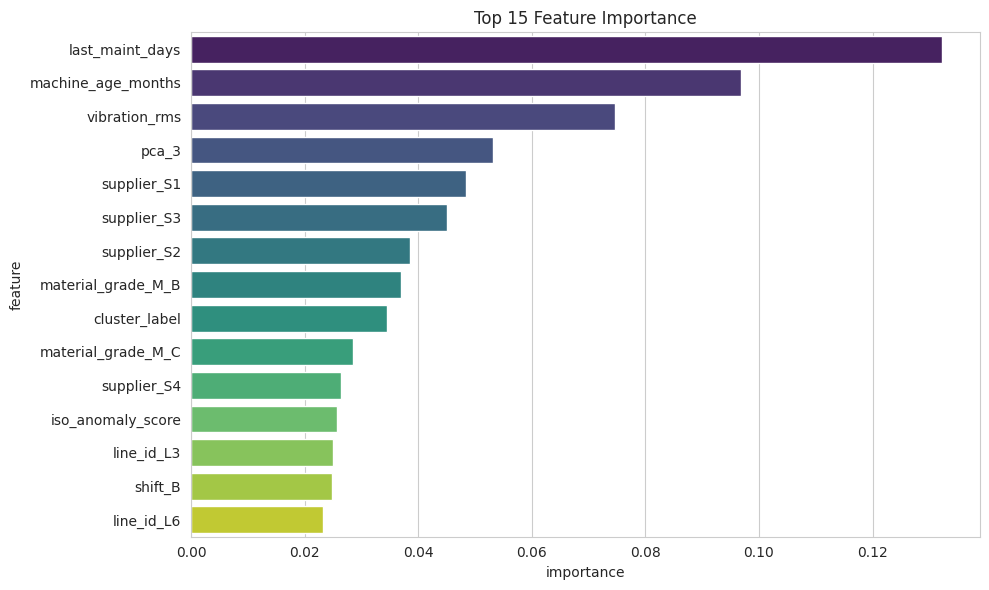

In [14]:
# Feature Importance
importance_df = pd.DataFrame({'feature': X_train_final.columns, 'importance': model.feature_importances_}).sort_values('importance', ascending=False)
print('Top 10 Features:')
print(importance_df.head(10).to_string(index=False))

plt.figure(figsize=(10, 6))
sns.barplot(x='importance', y='feature', data=importance_df.head(15), palette='viridis')
plt.title('Top 15 Feature Importance')
plt.tight_layout()
plt.show()

---
## 4️⃣ 임계값 탐색 및 이상 판정

In [15]:
# F1 기준 최적 임계값
precisions, recalls, thresholds = precision_recall_curve(y_valid_final, y_pred_proba)
f1_scores = 2 * (precisions * recalls) / (precisions + recalls + 1e-10)
best_idx = np.argmax(f1_scores[:-1])
best_threshold_f1 = thresholds[best_idx]
best_f1 = f1_scores[best_idx]

print(f'F1 Optimal Threshold: {best_threshold_f1:.4f}')
print(f'Best F1: {best_f1:.4f}, Precision: {precisions[best_idx]:.4f}, Recall: {recalls[best_idx]:.4f}')

F1 Optimal Threshold: 0.4325
Best F1: 0.7919, Precision: 0.7564, Recall: 0.8310


In [16]:
# Top 5% 기준
threshold_top5 = np.percentile(y_pred_proba, 95)
y_pred_top5 = (y_pred_proba >= threshold_top5).astype(int)
prec_top5 = precision_score(y_valid_final, y_pred_top5)
rec_top5 = recall_score(y_valid_final, y_pred_top5)
f1_top5 = f1_score(y_valid_final, y_pred_top5)

print(f'Top 5% Threshold: {threshold_top5:.4f}')
print(f'Precision: {prec_top5:.4f}, Recall: {rec_top5:.4f}, F1: {f1_top5:.4f}')

Top 5% Threshold: 0.9878
Precision: 0.9600, Recall: 0.3380, F1: 0.5000


   Metric F1 Optimal Top 5%
Threshold     0.4325 0.9878
Precision     0.7564 0.9600
   Recall     0.8310 0.3380
 F1-Score     0.7919 0.5000


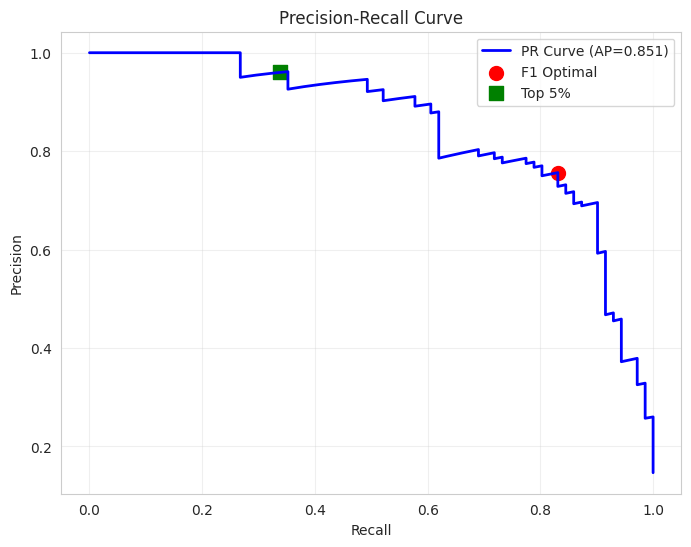

In [17]:
# 두 기준 비교
y_pred_f1_opt = (y_pred_proba >= best_threshold_f1).astype(int)

comparison = pd.DataFrame({
    'Metric': ['Threshold', 'Precision', 'Recall', 'F1-Score'],
    'F1 Optimal': [f'{best_threshold_f1:.4f}', f'{precision_score(y_valid_final, y_pred_f1_opt):.4f}', f'{recall_score(y_valid_final, y_pred_f1_opt):.4f}', f'{f1_score(y_valid_final, y_pred_f1_opt):.4f}'],
    'Top 5%': [f'{threshold_top5:.4f}', f'{prec_top5:.4f}', f'{rec_top5:.4f}', f'{f1_top5:.4f}']
})
print(comparison.to_string(index=False))

# PR Curve
plt.figure(figsize=(8, 6))
ap = average_precision_score(y_valid_final, y_pred_proba)
plt.plot(recalls, precisions, 'b-', lw=2, label=f'PR Curve (AP={ap:.3f})')
plt.scatter([recalls[best_idx]], [precisions[best_idx]], c='red', s=100, label=f'F1 Optimal')
idx_top5 = np.argmin(np.abs(thresholds - threshold_top5))
plt.scatter([recalls[idx_top5]], [precisions[idx_top5]], c='green', s=100, marker='s', label='Top 5%')
plt.xlabel('Recall'); plt.ylabel('Precision')
plt.title('Precision-Recall Curve')
plt.legend(); plt.grid(alpha=0.3)
plt.show()

---
## 5️⃣ 이상 샘플 리포트 출력

In [18]:
# 상위 5% 이상 샘플 추출
report_df = X_valid_orig_clean[CAT_COLS].copy()
report_df['score'] = y_pred_proba
report_df['eol_fail'] = y_valid_final.values

threshold_5pct = np.percentile(y_pred_proba, 95)
anomaly_df = report_df[report_df['score'] >= threshold_5pct]
anomaly_sorted = anomaly_df.sort_values('score', ascending=False)

print(f'상위 5% 임계값: {threshold_5pct:.4f}')
print(f'이상 판정 샘플: {len(anomaly_sorted)}개')
print(f'실제 불량(TP): {anomaly_sorted["eol_fail"].sum()}개, 오탐(FP): {(anomaly_sorted["eol_fail"]==0).sum()}개')

상위 5% 임계값: 0.9878
이상 판정 샘플: 25개
실제 불량(TP): 24개, 오탐(FP): 1개


In [19]:
# 상위 30건 출력
output_cols = ['line_id', 'shift', 'supplier', 'material_grade', 'score', 'eol_fail']
top_30 = anomaly_sorted[output_cols].head(30).copy()
top_30['score'] = top_30['score'].round(6)
print(top_30.to_string())

    line_id shift supplier material_grade     score  eol_fail
404      L1     A       S4            M_A  0.999784         1
161      L5     B       S1            M_A  0.999624         1
369      L6     C       S1            M_C  0.999542         1
299      L2     B       S3            M_B  0.999449         1
129      L1     A       S3            M_A  0.999442         1
31       L5     A       S3            M_A  0.999312         1
309      L3     B       S2            M_A  0.999208         1
68       L3     A       S3            M_A  0.999098         1
420      L4     A       S4            M_A  0.998626         1
141      L3     C       S3            M_A  0.998491         1
354      L3     A       S4            M_A  0.998411         1
158      L5     A       S2            M_A  0.998403         1
256      L2     B       S4            M_C  0.997561         1
452      L5     C       S4            M_B  0.997330         1
260      L4     A       S1            M_A  0.997028         1
169     

In [20]:
# 이상 샘플 패턴 분석
print('범주별 이상 샘플 분포:')
for col in CAT_COLS:
    print(f'\n[{col}]')
    for val, cnt in anomaly_sorted[col].value_counts().items():
        print(f'  {val}: {cnt}개 ({cnt/len(anomaly_sorted)*100:.1f}%)')

범주별 이상 샘플 분포:

[line_id]
  L4: 6개 (24.0%)
  L5: 5개 (20.0%)
  L3: 5개 (20.0%)
  L2: 4개 (16.0%)
  L6: 3개 (12.0%)
  L1: 2개 (8.0%)

[shift]
  A: 13개 (52.0%)
  B: 8개 (32.0%)
  C: 4개 (16.0%)

[supplier]
  S1: 9개 (36.0%)
  S3: 7개 (28.0%)
  S4: 5개 (20.0%)
  S2: 4개 (16.0%)

[material_grade]
  M_A: 16개 (64.0%)
  M_B: 6개 (24.0%)
  M_C: 3개 (12.0%)


In [21]:
# 최종 요약
roc_auc = roc_auc_score(y_valid_final, y_pred_proba)
f1_default = f1_score(y_valid_final, y_pred)

print('=' * 50)
print('최종 결과 요약')
print('=' * 50)
print(f'데이터: {len(df):,}개 (Train: {len(X_train_final)}, Valid: {len(X_valid_final)})')
print(f'불균형 비율: {imbalance_ratio:.2f}:1')
print(f'전처리: StandardScaler + One-Hot + IQR이상치제거')
print(f'비지도 잠재특징: PCA(3) + IsolationForest(1) + KMeans(2)')
print(f'모델: XGBoost (SMOTE + scale_pos_weight)')
print(f'성능: ROC-AUC={roc_auc:.4f}, F1(0.5)={f1_default:.4f}, F1(opt)={best_f1:.4f}')
print(f'임계값: F1 Optimal={best_threshold_f1:.4f}, Top 5%={threshold_top5:.4f}')
print(f'이상탐지: Top 5% 판정 {len(anomaly_sorted)}개 중 실제 불량 {anomaly_sorted["eol_fail"].sum()}개')
print('\n✅ 분석 완료')

최종 결과 요약
데이터: 2,500개 (Train: 1933, Valid: 484)
불균형 비율: 5.67:1
전처리: StandardScaler + One-Hot + IQR이상치제거
비지도 잠재특징: PCA(3) + IsolationForest(1) + KMeans(2)
모델: XGBoost (SMOTE + scale_pos_weight)
성능: ROC-AUC=0.9599, F1(0.5)=0.7801, F1(opt)=0.7919
임계값: F1 Optimal=0.4325, Top 5%=0.9878
이상탐지: Top 5% 판정 25개 중 실제 불량 24개

✅ 분석 완료
